In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 20.7 MB/s 


In [20]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image, ImageOps
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
%matplotlib inline
from tensorflow.keras import layers, models, optimizers, preprocessing, applications
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop


In [21]:
image_size = 224
batch_size = 32

In [22]:
# folders with train dir & val dir
train_dir = '/content/drive/MyDrive/Banana-Disease-Classifier/Datasets/final-banana-diseases-dataset/train'
val_dir = '/content/drive/MyDrive/Banana-Disease-Classifier/Datasets/final-banana-diseases-dataset/val'
test_dir = '/content/drive/MyDrive/Banana-Disease-Classifier/Datasets/final-banana-diseases-dataset/test'
input_shape = (image_size, image_size, 3)

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow.keras as keras

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 2400 images belonging to 5 classes.


In [25]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 307 images belonging to 5 classes.


In [26]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 300 images belonging to 5 classes.


In [27]:
train_generator.class_indices

{'bunchy-top': 0, 'fusarium-wilt': 1, 'healthy': 2, 'moko': 3, 'sigatoka': 4}

In [28]:
pretrained_model = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size,3))
#pretrained_model.summary()

output = pretrained_model.layers[-1].output
output = tf.keras.layers.Flatten()(output)
pretrained_model = Model(pretrained_model.input, output)

res_name = []
for layer in pretrained_model.layers:
    res_name.append(layer.name)

In [29]:
res_name[-22:]

['conv5_block1_out',
 'conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'flatten_1']

In [30]:
set_trainable = False
for layer in pretrained_model.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [32]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

#filepath='/content/drive/MyDrive/Banana-Disease-Classifier/Final-Classifier/Training-Checkpoints/Resnet50-Checkpoints/resnet50_best-1.h5'
#checkpoint_dir = os.path.dirname(filepath)
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
#                             save_best_only=True, mode='min')
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )
callbacks_list = [learning_rate_reduction,early_stop]

num_classes = 5

model = Sequential()
model.add(pretrained_model)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100352)            23587712  
                                                                 
 dense_3 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 127,403,909
Trainable params: 112,747,52

In [33]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [34]:
steps_per_epoch = 40
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=20,verbose=2)

Epoch 1/20
40/40 - 752s - loss: 2.4181 - accuracy: 0.5984 - f1_score: 0.5962 - val_loss: 1.2512 - val_accuracy: 0.7500 - val_f1_score: 0.7439 - lr: 1.0000e-04 - 752s/epoch - 19s/step
40/40 - 356s - loss: 0.8513 - accuracy: 0.8211 - f1_score: 0.8198 - val_loss: 1.2550 - val_accuracy: 0.8062 - val_f1_score: 0.7971 - lr: 1.0000e-04 - 356s/epoch - 9s/step
Epoch 3/20
40/40 - 164s - loss: 0.6446 - accuracy: 0.8570 - f1_score: 0.8583 - val_loss: 2.0105 - val_accuracy: 0.7563 - val_f1_score: 0.7392 - lr: 1.0000e-04 - 164s/epoch - 4s/step
Epoch 4/20
40/40 - 85s - loss: 0.5030 - accuracy: 0.8766 - f1_score: 0.8758 - val_loss: 1.3786 - val_accuracy: 0.7812 - val_f1_score: 0.7690 - lr: 1.0000e-04 - 85s/epoch - 2s/step
Epoch 5/20
40/40 - 46s - loss: 0.3932 - accuracy: 0.8961 - f1_score: 0.8965 - val_loss: 1.0148 - val_accuracy: 0.8375 - val_f1_score: 0.8211 - lr: 1.0000e-04 - 46s/epoch - 1s/step
Epoch 6/20
40/40 - 34s - loss: 0.2836 - accuracy: 0.9242 - f1_score: 0.9248 - val_loss: 1.4947 - val_acc

In [35]:
test_score = model.evaluate_generator(test_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 89.33%
[INFO] Loss:  0.7919126152992249


Text(0.5, 1.0, 'Accuracy Curves')

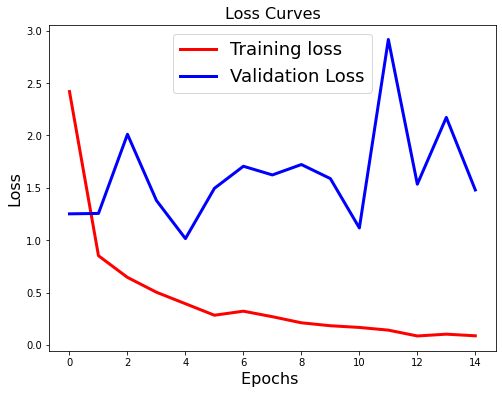

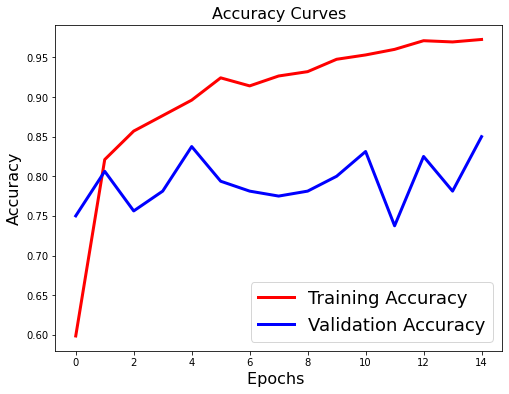

In [36]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [37]:
model.save('/content/drive/MyDrive/Banana-Disease-Classifier/Streamlit app file/resnet50-model.h5')